In [1]:
import vrep 
import sys
import time 
import numpy as np
from tank import *
from skfuzzy import control as ctrl

D:\Python\Skrypty\venv\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
D:\Python\Skrypty\venv\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


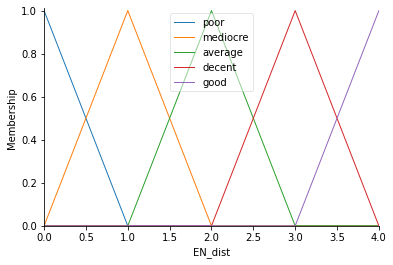

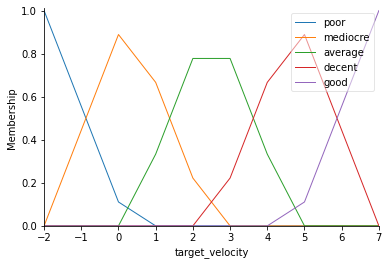

In [19]:
x_speeds = np.arange(-2, 8, 1)
x_distances = np.arange(0, 5, 1)

EN_dist = ctrl.Antecedent(x_distances, 'EN_dist')
ES_dist = ctrl.Antecedent(x_distances, 'ES_dist')
SE_dist = ctrl.Antecedent(x_distances, 'SE_dist')

target_velocity = ctrl.Consequent(x_speeds, 'target_velocity')

EN_dist.automf(5)
ES_dist.automf(5)
SE_dist.automf(5)
target_velocity.automf(5)

rules = (
    ctrl.Rule(EN_dist['mediocre'] & ES_dist['average'] & SE_dist['decent'], target_velocity['poor']),
    ctrl.Rule(EN_dist['poor'] & ES_dist['poor'] & SE_dist['average'], target_velocity['decent']),
    ctrl.Rule(EN_dist['poor'] & ES_dist['poor'] & SE_dist['poor'], target_velocity['good']),
    ctrl.Rule(EN_dist['good'] | ES_dist['good'], target_velocity['good']),
)

driver = ctrl.ControlSystemSimulation(ctrl.ControlSystem(rules=rules))

EN_dist.view(sim=driver)
target_velocity.view(sim=driver)

In [32]:
vrep.simxFinish(-1) # closes all opened connections, in case any prevoius wasnt finished
clientID=vrep.simxStart('127.0.0.1',19999,True,True,5000,5) # start a connection

if clientID!=-1:
    print ("Connected to remote API server")
else:
    print("Not connected to remote API server")
    sys.exit("Could not connect")

#create instance of Tank
tank=Tank(clientID)

proximity_sensors=["EN","ES","NE","NW","SE","SW","WN","WS"]
proximity_sensors_handles=[0]*8

# get handle to proximity sensors
for i in range(len(proximity_sensors)):
    err_code,proximity_sensors_handles[i] = vrep.simxGetObjectHandle(clientID,"Proximity_sensor_"+proximity_sensors[i], vrep.simx_opmode_blocking)

#read and print values from proximity sensors
#first reading should be done with simx_opmode_streaming, further with simx_opmode_buffer parameter
for sensor_name, sensor_handle in zip(proximity_sensors,proximity_sensors_handles):
        err_code,detectionState,detectedPoint,detectedObjectHandle,detectedSurfaceNormalVector=vrep.simxReadProximitySensor(clientID,sensor_handle,vrep.simx_opmode_streaming)


Connected to remote API server


In [33]:

while True:
    err_code,_,EN_detectedPoint,_,_=vrep.simxReadProximitySensor(clientID,proximity_sensors_handles[0],vrep.simx_opmode_buffer )
    # if not err_code:
    EN_curr_dist = np.linalg.norm(EN_detectedPoint)
    # else:
    #     EN_curr_dist = 100

    err_code,_,ES_detectedPoint,_,_=vrep.simxReadProximitySensor(clientID,proximity_sensors_handles[1],vrep.simx_opmode_buffer )
    # if not err_code:
    ES_curr_dist = np.linalg.norm(ES_detectedPoint)
    # else:
    #     ES_curr_dist = 100

    err_code,_,SE_detectedPoint,_,_=vrep.simxReadProximitySensor(clientID,proximity_sensors_handles[5],vrep.simx_opmode_buffer )
    # if not err_code:
    SE_curr_dist = np.linalg.norm(SE_detectedPoint)
    # else:
    #     SE_curr_dist = 100

    driver.input['EN_dist'] = EN_curr_dist
    driver.input['ES_dist'] = ES_curr_dist
    driver.input['SE_dist'] = SE_curr_dist

    driver.compute()

    target = driver.output['target_velocity']

    print(f'\rEN_dist: {EN_curr_dist:.2f}, ES_dist: {ES_curr_dist:.2f}, SE_dist: {SE_curr_dist:.2f}, target_velocity: {target:.2f}', end='')
    if target <= 0.5:
        target = 0

    tank.forward(target)


EN_dist: 0.00, ES_dist: 0.00, SE_dist: 0.00, target_velocity: 6.190

KeyboardInterrupt: 